In [1]:
%matplotlib inline
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
plt.ion()   # interactive mode
#from scipy.misc import imread, imresize
#from scipy.misc.pilutil import imread
from imageio import imread
import Augmentor
torch.cuda.empty_cache()
torch.cuda.is_available()

ModuleNotFoundError: No module named 'Augmentor'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
################## ONlY in THE DATA PREPERATION ##############################
def resize_image(image, size):
    return image.resize(size, Image.ANTIALIAS)

def resize_images(image_dir, output_dir, size):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    images = os.listdir(image_dir)
    num_images = len(images)
    for i, image in enumerate(images):
        with open(os.path.join(image_dir, image), 'r+b') as f:
            with Image.open(f) as img:
                try:
                    img = resize_image(img, size)
                    img.save(os.path.join(output_dir, image), img.format)
                except:
                    print("Cannot read image")
        if (i+1) % 100 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_images, output_dir))
image_dir = './resized/val/Moderate/'        
output_dir = './resized/Moderate/'
image_size = [64, 64]
resize_images(image_dir, output_dir, image_size)

In [ ]:
################## ONlY in THE DATA PREPERATION ##############################
p = Augmentor.Pipeline("resized/val/Moderate")
p.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
p.sample(5000)

In [2]:
################## TRAIN ##############################

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    'val': transforms.Compose([transforms.Resize(224), transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),}

data_dir = 'resized'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
################## TRAIN ##############################
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

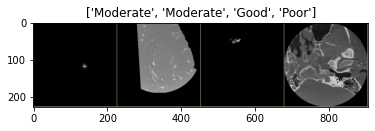

In [4]:
################## TRAIN ##############################

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [5]:
################## TRAIN ##############################

Training_loss = []
Test_loss = []
Training_accurecy = []
Test_accurecy = []



def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            
            
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
        
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if phase == 'train':
                Training_loss.append(epoch_loss)
                Training_accurecy.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                Test_loss.append(epoch_loss)
                Test_accurecy.append(epoch_acc)
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
################## TRAIN ##############################
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
class OurVGG11(nn.Module):

    def __init__(self, num_classes=3):
        super(OurVGG11, self).__init__()
        self.vgg11 = torchvision.models.alexnet(pretrained=True)
        for param in self.vgg11.parameters():
            param.requires_grad = False

        # Add a avgpool here
       # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # Replace the classifier layer
        self.vgg11.classifier[-1] = nn.Linear(4096, num_classes)


    def forward(self, x):
        x = self.vgg11.features(x)
        x = self.avgpool(x)
        #x = x.view(x.size(0), 512 * 7 * 7)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.vgg11.classifier(x)
        return x
    
    
    
model_ft = OurVGG11()
print(model_ft)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\user/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

OurVGG11(
  (vgg11): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1

In [8]:
################## TRAIN ##############################
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=5)


Epoch 0/4
----------


C:\Users\user\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


train Loss: 2.7755 Acc: 0.7038
val Loss: 1.0655 Acc: 0.8184

Epoch 1/4
----------
train Loss: 2.1464 Acc: 0.7861
val Loss: 0.8219 Acc: 0.8389

Epoch 2/4
----------
train Loss: 2.1020 Acc: 0.8073
val Loss: 0.7791 Acc: 0.8785

Epoch 3/4
----------
train Loss: 1.8222 Acc: 0.8373
val Loss: 2.6660 Acc: 0.7906

Epoch 4/4
----------
train Loss: 1.8672 Acc: 0.8358
val Loss: 0.4340 Acc: 0.9297

Training complete in 1m 40s
Best val Acc: 0.929722


In [9]:
torch.save(model_ft.state_dict(), 'MsHasanah_alexnet.pth.tar')
torch.cuda.empty_cache()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = OurVGG11()
model_ft = model_ft.to(device)
model_ft.load_state_dict(torch.load('MsHasanah_alexnet.pth.tar'))
class_names = ['Good', 'Moderate', 'Poor']

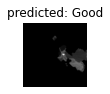

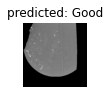

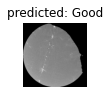

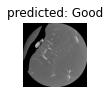

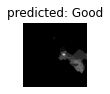

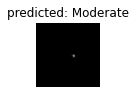

In [11]:
################## TRAIN ##############################
model_ft.eval()
visualize_model(model_ft)

In [12]:
from torch.autograd import Variable 
imsize = 63
loader = transforms.Compose([transforms.Scale(imsize), transforms.ToTensor(),
                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

def image_loader(image_name):
    """load image, returns cuda tensor"""
    image = Image.open(image_name)
    image = image.convert('RGB')
    image = loader(image).float()
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    return image.cuda()  #assumes that you're using GPU

image = image_loader('test1.png')
model_ft.eval()
with torch.no_grad():
    outputs = model_ft(image)
    _, preds = torch.max(outputs, 1)
    print("predicted: {}".format(class_names[preds]))

predicted: Good


C:\Users\user\anaconda3\lib\site-packages\torchvision\transforms\transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


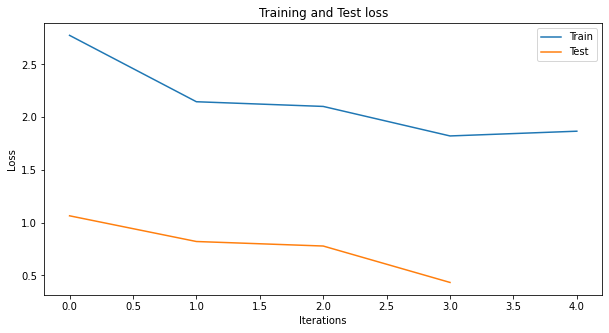

In [22]:
plt.figure(figsize=(10,5))
plt.title("Training and Test loss")
plt.plot(Training_loss,label="Train")
plt.plot(Test_loss,label="Test")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

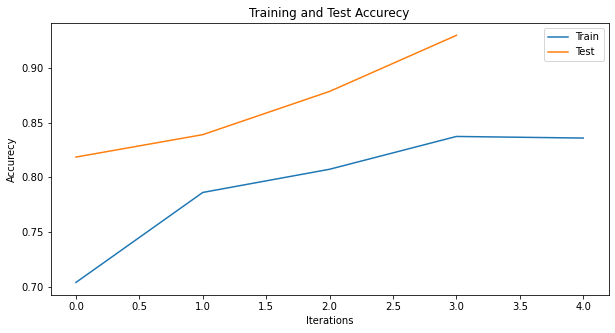

In [68]:
TT0 = Training_accurecy[0].cpu().detach().numpy()
TT1 = Training_accurecy[1].cpu().detach().numpy()
TT2 = Training_accurecy[2].cpu().detach().numpy()
TT3 = Training_accurecy[3].cpu().detach().numpy()
TT4 = Training_accurecy[4].cpu().detach().numpy()
TrainACC = [TT0, TT1, TT2, TT3, TT4]
TrainACC = np.vstack(TrainACC)

Ts0 = Test_accurecy[0].cpu().detach().numpy()
Ts1 = Test_accurecy[1].cpu().detach().numpy()
Ts2 = Test_accurecy[2].cpu().detach().numpy()
Ts3 = Test_accurecy[3].cpu().detach().numpy()
TestACC = [Ts0, Ts1, Ts2, Ts3]
TestACC = np.vstack(TestACC)


plt.figure(figsize=(10,5))
plt.title("Training and Test Accurecy")
plt.plot(TrainACC,label="Train")
plt.plot(TestACC,label="Test")
plt.xlabel("Iterations")
plt.ylabel("Accurecy")
plt.legend()
plt.show()

In [62]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[230  17   2]
 [ 26 290   0]
 [  3   0 115]]
[92.36947791 91.7721519  97.45762712]


In [63]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[230  17   2]
 [ 26 290   0]
 [  3   0 115]]


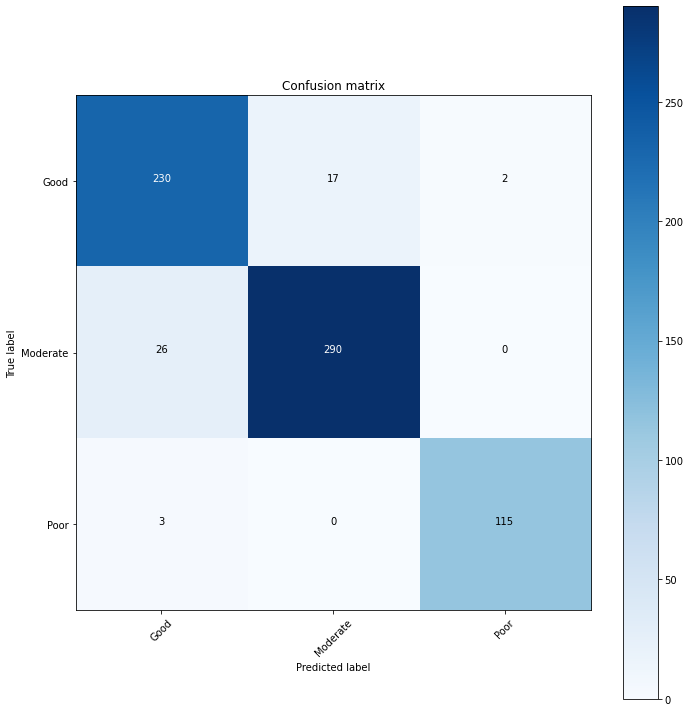

In [64]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_mat, class_names)

In [65]:
from sklearn.metrics import confusion_matrix

nb_classes = 3

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['train']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 964   32    0]
 [ 102 1164    1]
 [   5    0  467]]
[96.78714859 91.87056038 98.94067797]


Confusion matrix, without normalization
[[ 964   32    0]
 [ 102 1164    1]
 [   5    0  467]]


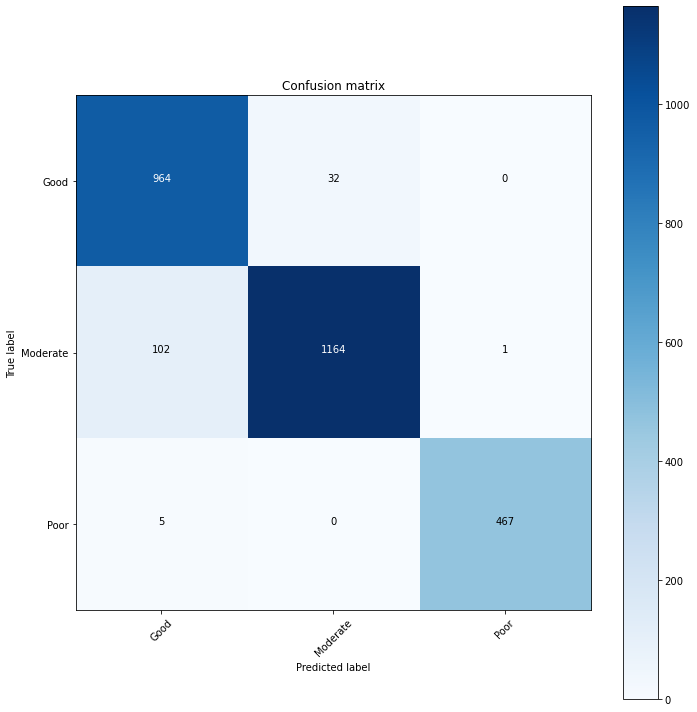

In [66]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_mat, class_names)